In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Import necessary packages

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('gdrive/My Drive/Pucho')
plt.style.use("ggplot")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading

In [0]:
data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [0]:
data.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


## Data Pre-processing

In [0]:
train =data.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos","shape"],axis=1)

In [0]:
# Create list of list of tuples to differentiate each sentence from each other
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(train)

In [0]:
sentences = getter.sentences

In [0]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [0]:
# Total words used in training corpus
words = list(set(train["word"].values))
words.append("ENDPAD")
print(len(words))

30174


In [0]:
# Total tags for words
tags = list(set(train["tag"].values))
print(len(tags))

18


In [0]:
# Create diction for each word & tags
word2idx = {}
i=0
for word in words:
    word2idx.update({word:i})
    i+=1
     
tag2idx = {}
i=0
for tag in tags:
    tag2idx.update({tag:i})
    i+=1

In [0]:
index = np.random.randint(low= 0,high=len(words))
print(words[index],"-->",word2idx[words[index]])

Derg --> 12629


## Data Visualization

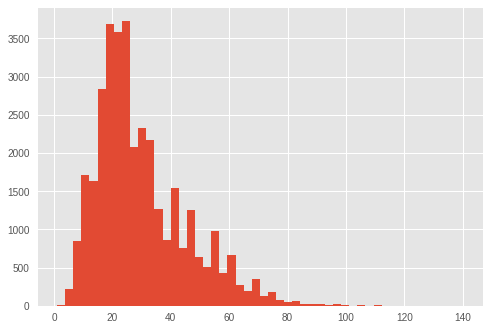

In [0]:
# Sentence length distribution
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [0]:
# Top 10 most frequently occuring words in corpus
count = [0]*(len(words)+1)
for s in sentences:
    for word in s:
        count[word2idx[word[0]]]+=1
count = np.array(count)
index = np.argsort(count)  
index = index[::-1]

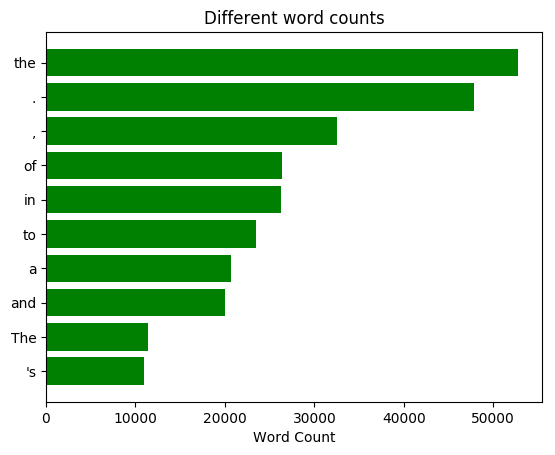

In [0]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = [words[index[i]] for i in range(10)]
y_pos = np.arange(len(people))
performance = [count[index[i]] for i in range(10)]
error = np.random.rand(len(people))
ax.barh(y_pos, performance, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Word Count')
ax.set_title('Different word counts')
plt.show()

In [0]:
def Plot_Tag(tag,topk=10,color='green'):
    if tag not in tags:
        print("No such tags found in training label")
    else:
        count = [0]*(len(words)+1)
        for s in sentences:
            for word in s:
                if(word[1]==tag):
                    count[word2idx[word[0]]]+=1
        count = np.array(count)
        index = np.argsort(count)  
        index = index[::-1]
        plt.rcdefaults()
        fig, ax = plt.subplots()

        # Example data
        people = [words[index[i]] for i in range(topk)]
        y_pos = np.arange(len(people))
        performance = [count[index[i]] for i in range(topk)]
        error  =0 
        ax.barh(y_pos, performance, xerr=error, align='center',
                color=color, ecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(people)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel( tag+' Count')
        ax.set_title('Different ' +" "+tag+ ' counts')
        plt.show()

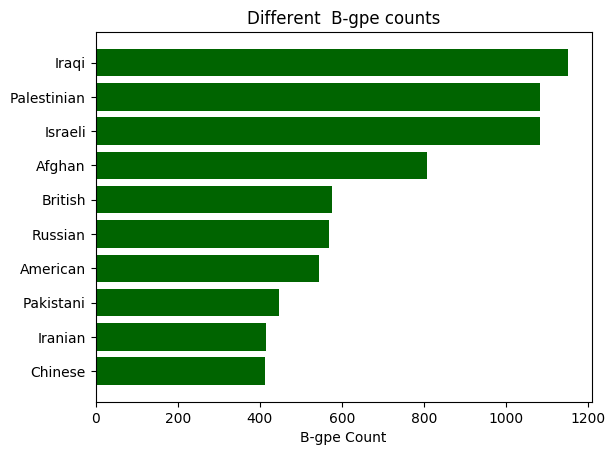

In [0]:
# Most frequently used citizens in corpus
Plot_Tag(tag='B-gpe',color='darkgreen')

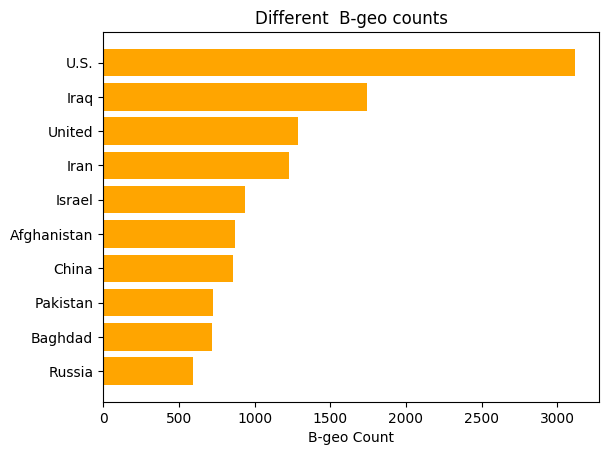

In [0]:
# Some of the most frequently used countries in training corpus
Plot_Tag(tag='B-geo',color='orange')

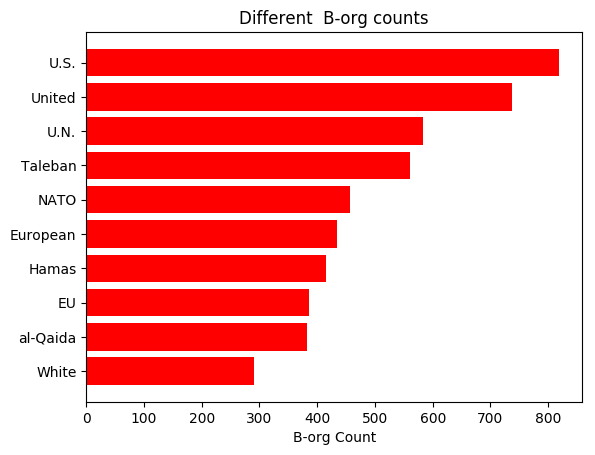

In [0]:
# Some of the most frequently used organization in training corpus
Plot_Tag(tag='B-org',color='red')

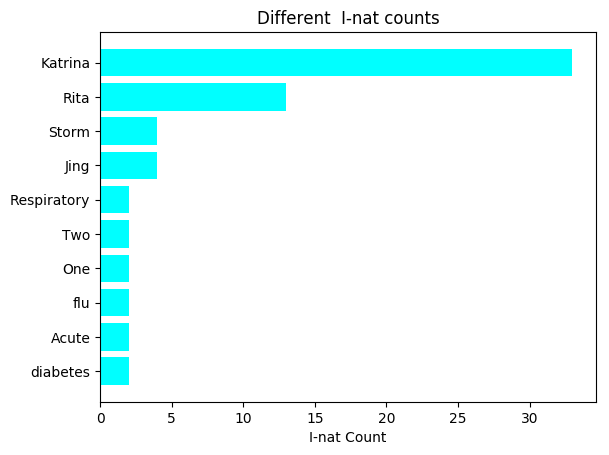

In [0]:
# Some of the most frequently used topics/Natual Calamities in training corpus
Plot_Tag(tag='I-nat',color='cyan')

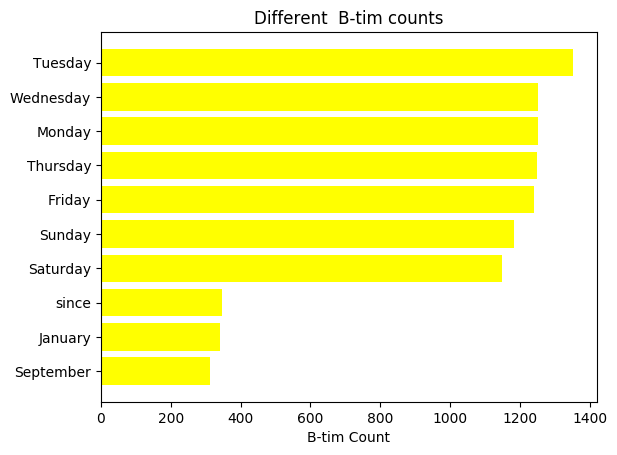

In [0]:
# Some of the most frequently used time in training corpus
Plot_Tag(tag='B-tim',color='yellow')

## Splitting data into training and test data

In [0]:
X = [[[word2idx[w[0]] for w in s]] for s in sentences]

y = [[tag2idx[w[1]] for w in s] for s in sentences]


# Split the data into training & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Total number of training example: "+str(len(X_train)))
print("Total number of test example: "+str(len(X_test)))

inputs_train = []
labels_train = []
sequence_length_train = []

for i in range(len(X_train)):
    inputs_train.append(Variable(torch.LongTensor(X_train[i])).to(device))
    labels_train.append(Variable(torch.LongTensor(y_train[i])).to(device))
    sequence_length_train.append(len(X_train[i][0]))

Total number of training example: 28141
Total number of test example: 7036


In [0]:
# Define Model Parameter
num_classes = len(tags)
input_size = len(words)  # Vocabulary size
embedding_size = 10  # embedding size
hidden_size = len(tags)  # output from the LSTM (feed to fully connected layer)
batch_size = 1   # one sentence (We taking one sentence at a time as sentence are of different lenght)
num_layers = 1  # one-layer rnn

## Model Training

In [0]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
    
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size,hidden_size=hidden_size, batch_first=True,bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x,sequence_length):
        # Initialize hidden
        # (num_layers , batch, hidden_size)
        
        h0 = Variable(torch.zeros(num_layers, x.size(0), hidden_size)).to(device)
        #c0 = Variable(torch.zeros(num_layers*2, x.size(0), hidden_size)).to(device)

        emb = self.embedding(x)
        emb = emb.view(batch_size, sequence_length, -1)

        # Propagate embedding through RNN
        # Input: (batch, seq_len, embedding_size)
        # h_0: (num_layers * num_directions, batch, hidden_size)
        out, _ = self.rnn(emb, h0)
        return self.fc(out.view(-1, num_classes))

In [0]:
model = Model()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [0]:
test_total = sum(sequence_length_train)
for epoch in range(10):
    cum_loss =0
    
    test_correct =0
    for i in range(len(X_train)):
        outputs = model.forward(inputs_train[i],sequence_length_train[i])
        #print(outputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels_train[i])
        cum_loss +=loss.item()
        loss.backward()
        optimizer.step()
        _, test_predicted = torch.max(outputs.data, 1)
        test_correct += (test_predicted == labels_train[i]).sum().item()
        
    print('Epoch [{:d}], train accuracy: {:4.2f} %, average train_loss {:.3f}'.format(epoch+1, 100*test_correct/test_total, cum_loss/len(X_train)))

Epoch [1], train accuracy: 92.72 %, average train_loss 0.264
Epoch [2], train accuracy: 94.81 %, average train_loss 0.182
Epoch [3], train accuracy: 95.39 %, average train_loss 0.163
Epoch [4], train accuracy: 95.63 %, average train_loss 0.156
Epoch [5], train accuracy: 95.80 %, average train_loss 0.149
Epoch [6], train accuracy: 95.91 %, average train_loss 0.145
Epoch [7], train accuracy: 96.01 %, average train_loss 0.141
Epoch [8], train accuracy: 96.05 %, average train_loss 0.141
Epoch [9], train accuracy: 96.14 %, average train_loss 0.139
Epoch [10], train accuracy: 96.18 %, average train_loss 0.139


In [0]:
inputs_test = []
labels_test = []
sequence_length_test = []

for i in range(len(X_test)):
    inputs_test.append(Variable(torch.LongTensor(X_test[i])).to(device))
    labels_test.append(Variable(torch.LongTensor(y_test[i])).to(device))
    sequence_length_test.append(len(X_test[i][0]))

In [0]:
test_correct =0
test_total = sum(sequence_length_test)
cum_loss =0
for i in range(len(X_test)):
    outputs = model.forward(inputs_test[i],sequence_length_test[i])
    cum_loss +=criterion(outputs,labels_test[i]).item()
    _, test_predicted = torch.max(outputs.data, 1)
    test_correct += (test_predicted == labels_test[i]).sum().item()
        
print('test accuracy: {:4.2f} %,average test_loss {:.3f}'.format( 100*test_correct/test_total, cum_loss/len(X_test)))

test accuracy: 94.79 %,average test_loss 0.193


In [0]:
# Model with embedding size =10
#torch.save(model.state_dict(),"/Model")